In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

from sklearn import metrics

%matplotlib inline

In [2]:
#Read in the csv file and convert to a Pandas dataframe
df = pd.read_csv('Data/final_data.csv')

In [3]:
df.shape

(10754, 22)

In [4]:
df.head(2)

,player,team,name,position,height,age,appearance,goals,assists,yellow cards,...,goals conceded,clean sheets,minutes played,days_injured,games_injured,award,current_value,highest_value,position_encoded,winger
0,/david-de-gea/profil/spieler/59377,Manchester United,David de Gea,Goalkeeper,189.0,32.0,104,0.0,0.0,0.009585,...,1.217252,0.335463,9390,42,5,13,15000000,70000000,1,0
1,/jack-butland/profil/spieler/128899,Manchester United,Jack Butland,Goalkeeper,196.0,30.0,15,0.0,0.0,0.069018,...,1.242331,0.207055,1304,510,58,1,1500000,22000000,1,0


In [5]:
df[df.duplicated()]

,player,team,name,position,height,age,appearance,goals,assists,yellow cards,...,goals conceded,clean sheets,minutes played,days_injured,games_injured,award,current_value,highest_value,position_encoded,winger


In [6]:
df.isnull().sum()

player                 0
team                   0
name                   0
position               0
height                 0
age                    0
appearance             0
goals                  0
assists                0
yellow cards           0
second yellow cards    0
red cards              0
goals conceded         0
clean sheets           0
minutes played         0
days_injured           0
games_injured          0
award                  0
current_value          0
highest_value          0
position_encoded       0
winger                 0
dtype: int64

In [7]:
df.dtypes

player                  object
team                    object
name                    object
position                object
height                 float64
age                    float64
appearance               int64
goals                  float64
assists                float64
yellow cards           float64
second yellow cards    float64
red cards              float64
goals conceded         float64
clean sheets           float64
minutes played           int64
days_injured             int64
games_injured            int64
award                    int64
current_value            int64
highest_value            int64
position_encoded         int64
winger                   int64
dtype: object

In [8]:
# Calculate the 35th and 75th percentiles of the price
p35 = df['current_value'].quantile(0.35)
p75 = df['current_value'].quantile(0.75)

# Function to categorize prices
def categorize_price(price):
    if price < p35:
        return 'Cheap_Price'
    elif price < p75:
        return 'Good_Price'
    else:
        return 'High_Price'

# Apply the function to create a new column
df['price_category'] = df['current_value'].apply(categorize_price)

df.drop('current_value', axis=1, inplace=True)

# Verify the distribution of the new categories
print(df['price_category'].value_counts())

price_category
Good_Price     4310
Cheap_Price    3754
High_Price     2690
Name: count, dtype: int64


In [9]:
encoder = LabelEncoder()
df['price_category_encoded'] = encoder.fit_transform(df['price_category']) 

In [10]:
correlation = df.corr(numeric_only=True)
#print(correlation['Price'].sort_values(ascending=False))
print(correlation['price_category_encoded'].sort_values(ascending=False))

price_category_encoded    1.000000
appearance                0.546979
minutes played            0.519476
highest_value             0.488265
award                     0.242359
games_injured             0.229243
days_injured              0.197838
assists                   0.163772
position_encoded          0.135433
goals                     0.120438
winger                    0.025773
height                    0.024424
age                       0.023627
yellow cards              0.012427
second yellow cards      -0.002912
red cards                -0.006292
clean sheets             -0.031388
goals conceded           -0.128555
Name: price_category_encoded, dtype: float64


In [11]:
threshold = 0.2  # You can change this value based on your requirement

# Filter the correlations
# We use `abs()` for absolute value to consider both strong positive and negative correlations
selected_features = correlation[abs(correlation['price_category_encoded']) > \
threshold]['price_category_encoded'].index
selected_features

Index(['appearance', 'minutes played', 'games_injured', 'award',
       'highest_value', 'price_category_encoded'],
      dtype='object')

In [12]:
df = df[selected_features]
df.head()

,appearance,minutes played,games_injured,award,highest_value,price_category_encoded
0,104,9390,5,13,70000000,2
1,15,1304,58,1,22000000,1
2,4,292,84,4,6000000,1
3,82,6408,22,9,50000000,2
4,63,5031,51,21,80000000,2


In [13]:
X = df.drop(['price_category_encoded'], axis=1)


# sacle the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [14]:
wcss = []
for i in range(1, 20):  # Test 1 to 10 clusters
    kmeans = KMeans(n_clusters=i,
                    init='k-means++',
                    max_iter=300,
                    n_init=10,
                    random_state=0)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

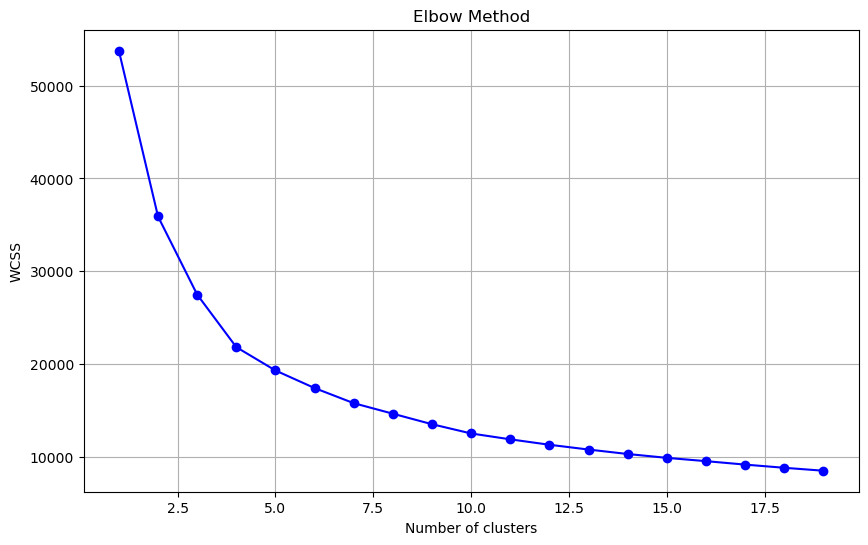

In [15]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, 20), wcss,  marker='o', linestyle='-', color='b')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.grid(True)
plt.show()

In [16]:
optimal_clusters = 5 # This might change based on your actual elbow curve analysis
model = KMeans(n_clusters=optimal_clusters, init='k-means++', max_iter=300, n_init=10, random_state=0)

In [17]:
y_pred = model.fit_predict(X_scaled)

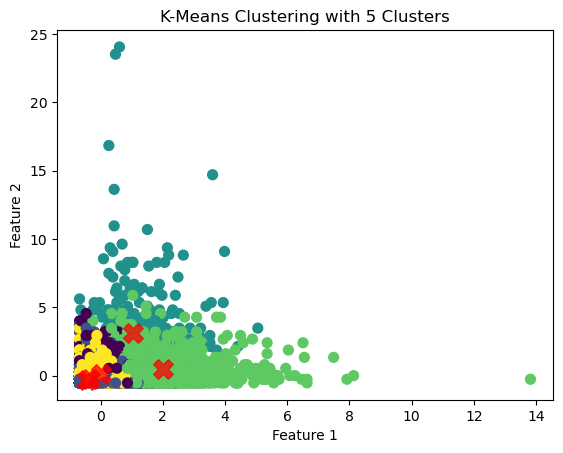

In [18]:
plt.scatter(X_scaled[:, 2], X_scaled[:, 3], c=y_pred, s=50, cmap='viridis')

centers = model.cluster_centers_
plt.scatter(centers[:, 2], centers[:, 3], c='red', s=200, alpha=0.75, marker='X')
plt.title(f'K-Means Clustering with {optimal_clusters} Clusters')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

In [19]:
X['kmeans'] = y_pred

In [20]:
X['kmeans'].value_counts()

kmeans
1    4383
4    2919
0    1899
3    1238
2     315
Name: count, dtype: int64

In [21]:
X[X['kmeans']==0]

,appearance,minutes played,games_injured,award,highest_value,kmeans
9,74,5854,70,4,42000000,0
10,89,7132,15,3,22000000,0
12,72,5574,49,3,35000000,0
13,60,4783,20,1,40000000,0
15,76,4687,53,2,35000000,0
...,...,...,...,...,...,...
10672,64,5601,0,6,2000000,0
10674,55,4980,0,6,800000,0
10682,58,5026,28,4,1000000,0
10687,63,5387,0,3,600000,0


<Axes: xlabel='appearance', ylabel='minutes played'>

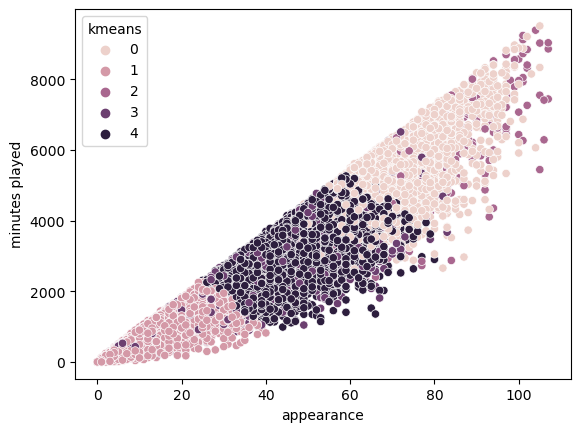

In [22]:
sns.scatterplot(data = X , x = 'appearance', y = 'minutes played', hue = 'kmeans')

<Axes: xlabel='award', ylabel='minutes played'>

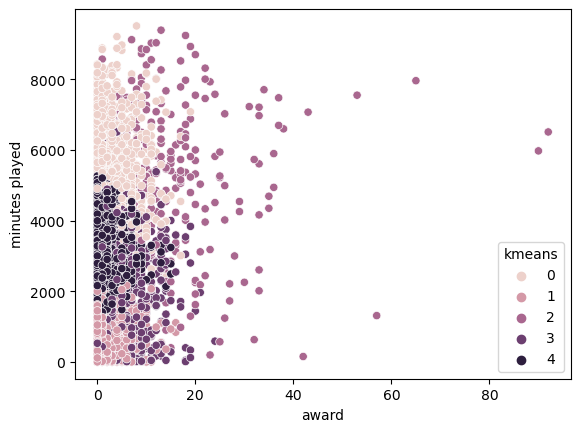

In [24]:
sns.scatterplot(data = X , x = 'award', y = 'minutes played', hue = 'kmeans')

<Axes: xlabel='appearance', ylabel='games_injured'>

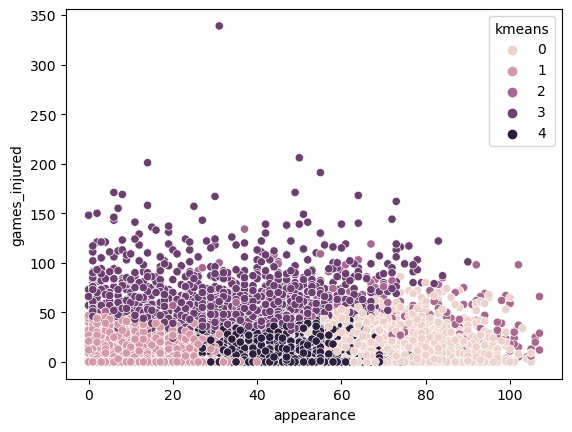

In [25]:
sns.scatterplot(data = X , x = 'appearance', y = 'games_injured', hue = 'kmeans')

# DBSCAN

In [13]:
X = df.drop(['price_category_encoded'], axis=1)


# sacle the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [14]:
min_samples = 2

In [15]:
nn = NearestNeighbors(n_neighbors=min_samples)
nn.fit(X_scaled)
distances, indices = nn.kneighbors(X_scaled)

In [16]:
distances[:,min_samples-1]

array([1.20146228, 0.57576855, 0.32711393, ..., 0.00717247, 0.0170646 ,
       0.03777628])

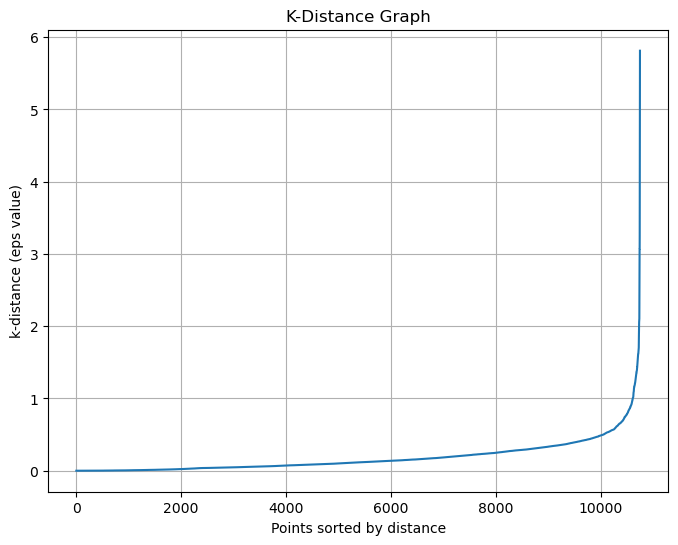

In [17]:
# The distance to the furthest neighbor (min_samples-th nearest) for each point
k_dist = distances[:, min_samples-1]

# Sort distances
k_dist_sorted = np.sort(k_dist)

# 3. Plotting the k-distance graph
plt.figure(figsize=(8, 6))
plt.plot(k_dist_sorted)
plt.title('K-Distance Graph')
plt.xlabel('Points sorted by distance')
plt.ylabel('k-distance (eps value)')
plt.grid(True)
plt.show()

In [18]:
chosen_eps = 0.6  # This is an example; choose this value based on the plot
dbscan = DBSCAN(eps=chosen_eps, min_samples=min_samples)

In [19]:
clusters = dbscan.fit_predict(X_scaled)

In [20]:
pd.Series(clusters).value_counts()

 0     10063
-1       462
 79        9
 24        7
 14        6
       ...  
 53        2
 54        2
 55        2
 25        2
 83        2
Name: count, Length: 85, dtype: int64

In [21]:
silhouette_avg = silhouette_score(X, clusters)
silhouette_avg

-0.8401110789199406

In [22]:
X.head(2)

,appearance,minutes played,games_injured,award,highest_value
0,104,9390,5,13,70000000
1,15,1304,58,1,22000000


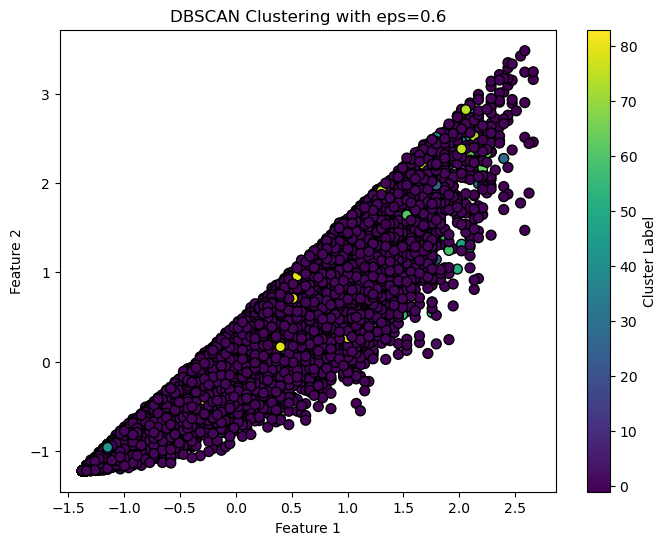

In [23]:
plt.figure(figsize=(8, 6))
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=clusters, cmap='viridis', s=50, edgecolor='k')
plt.title(f'DBSCAN Clustering with eps={chosen_eps}')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.colorbar(label='Cluster Label')
plt.show()

In [24]:
X['dbscan'] = clusters

In [25]:
X['dbscan'].value_counts()

dbscan
 0     10063
-1       462
 79        9
 24        7
 14        6
       ...  
 53        2
 54        2
 55        2
 25        2
 83        2
Name: count, Length: 85, dtype: int64

<Axes: xlabel='appearance', ylabel='minutes played'>

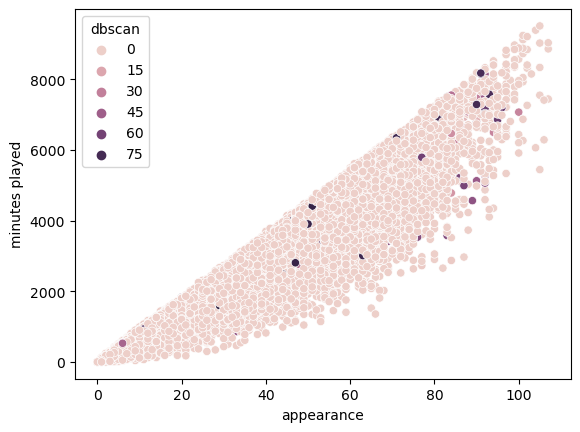

In [29]:
sns.scatterplot(data = X , x = 'appearance', y = 'minutes played', hue = 'dbscan')

<Axes: xlabel='minutes played', ylabel='award'>

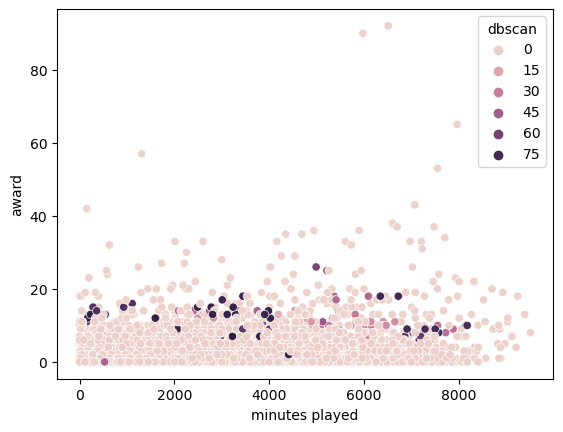

In [27]:
sns.scatterplot(data = X , x = 'minutes played', y = 'award', hue = 'dbscan')